# Link Prediction in Social Email Network
## Goal
The goal here was to provide a use case of grabbing structured data and performing analysis with that structured data. Mapping each user's social email network and also trying to predict the probability of a link between a set of users.

### Data
The data was gathered from the Microsoft Graph API. Using this API we were able to gather all users, their inbox and sent email folders, and who they received and sent emails to.

    Steps:
    1. Grab all user's email (userPrincipalName)
    2. For each email grab their mailFolders
        a. Parse out the inbox ID
    3. Create a df that holds each users email and their inbox ID
    4. 

### Workflow
1. Bring in raw data from MS Graph API
2. Clean up (formating, NA's, etc.)
3. EDA
4. Feature Engineering
5. Model
    - Split data into training and test sets
    - Use SVM or Logistic Regression 
        - These algo's are good for binary classification
        - Use metric report to a assess model performance (precision, recall, f1-score), confusion matrix, and ROC Curve. All of which will be explained in this section.
6. Results
7. Recommendation


In [574]:
# Lib's needed
import os
import adal
import time
import pickle
import random
import requests
import sys, json
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
plt.rcParams.update({'font.size': 22})

In [44]:
tenant = "ohMan.com"
client_id = "hahhahahahahahahahahha...nope"
client_secret = "hahahahhahahaa...gotcha"
authority = "https://ohMAN.com/" + tenant
RESOURCE = "https://ohMAN.ohMAN.com"

In [45]:
context = adal.AuthenticationContext(authority)

In [46]:
# Use this for Client Credentials
token = context.acquire_token_with_client_credentials(
   RESOURCE,
   client_id,
   client_secret
   )

headers = {'Content-Type':'application/json', 'Authorization':'Bearer {0}'.format(token['accessToken'])}

In [47]:
headers = {'Content-Type':'application/json', 'Authorization':'Bearer {0}'.format(token['accessToken'])}

In [6]:
# Get all of the users and save them to a Pandas df
user_df = pd.DataFrame()
email_address_endpoint = "https://graph.microsoft.com/v1.0/users?$select=userPrincipalName"

while True:
    users = requests.get(email_address_endpoint, headers=headers)
    user_data = json.loads(users.text)
    user_df = user_df.append(user_data.get('value'))
    if user_data.get('@odata.nextLink') is None:
        break
    else:
        email_address_endpoint = user_data.get('@odata.nextLink')
    

In [7]:
#658
user_df.shape

(658, 1)

In [10]:
# user_df.to_csv("MS Graph Data-All Users.csv", index=False)

In [293]:
user_inbox_id_df = pd.DataFrame()
user_sent_id_df = pd.DataFrame()
key_val_list = ['Inbox', 'Sent Items']

for user in user_df['userPrincipalName']:
    # State endpoint
    mailFolders_from_endpoint = "https://graph.microsoft.com/v1.0/users/{}/mailFolders?$select=displayName&$top=50".format(user)

    try:
        # Request data from inbo and sent
        mail_folder = requests.get(mailFolders_from_endpoint, headers=headers)
        # Load Request
        mail_folder_data = json.loads(mail_folder.text)
        # Go into dict and grab the value, which holds all the needed data
        # Now we have a list of dicts
        one_step_in = mail_folder_data.get('value')
        # The 'inbox' will always be the 5th element in here
        # THESE ARE NOT ALWAYS IN THE SAME PLACE!!!!!!!!!

        inbox = [d for d in one_step_in if d['displayName'] in key_val_list[0]]
        sent_to = [d for d in one_step_in if d['displayName'] in key_val_list[1]]

        # Save data to dict (THIS WILL ONLY CONTAIN PEOPLE WHO HAVE IN INBOX & SENT FOLDER)
        # WILL NOT INCLUDE PEOPLE OF HAVE MULTIPE FOLERS FOR THEIR CLIENT/TEAM INCOMING MAIL
        # Inbox Id's
        try:
            user_inbox_id = {'user': user, 'inbox_id': inbox[0]['id']}
            user_inbox_id_df = user_inbox_id_df.append(user_inbox_id, ignore_index=True)
        except IndexError as e:
            print(user, "does not have a Inbox folder with the default name")
        # Sent to Id's
        try:
            user_sent_id = {'user': user, 'sent_id': sent_to[0]['id']}
            user_sent_id_df = user_sent_id_df.append(user_sent_id, ignore_index=True)
        except IndexError as e:
            print(user, "does not have a Sent folder with the default name")
    except TypeError as e:
        pass



In [292]:
print(user_inbox_id_df.shape)
# user_inbox_id_df.head()

(317, 2)


In [291]:
print(user_sent_id_df.shape)
# user_sent_id_df.head()

(316, 2)


In [14]:
# Merge the inbox_id and sent_id df's
user_inbox_sent_id_df = pd.merge(user_inbox_id_df, user_sent_id_df, how='outer', on='user')
user_inbox_sent_id_df = user_inbox_sent_id_df[['user', 'inbox_id', 'sent_id']]
user_inbox_sent_id_df.shape

(317, 3)

In [290]:
# user_inbox_sent_id_df.head()

In [17]:
# user_inbox_sent_id_df.to_csv("MS Graph Data-All Users Inbox-Sent IDs.csv", index=False)

In [24]:
# INBOX FOLDER
# For each user, grab all of their inbox messages and store them in a Pandas df
# We need receivedDateTime, from, toRecipients
user_inbox_df = pd.DataFrame()

END_DATE = date.today()
START_DATE = END_DATE - timedelta(days=5)

for index, row in user_inbox_sent_id_df.iterrows():
    # Endpoint to get the emails in the users inbox
    inbox_endpoint = "https://graph.microsoft.com/v1.0/users/{}/mailFolders/{}/messages?$filter=ReceivedDateTime+ge+{}+and+receivedDateTime+lt+{}&select=receivedDateTime,from".format(row[0], row[1], START_DATE.isoformat(), END_DATE.isoformat())

    while True:
        # Make request
        users_inbox = requests.get(inbox_endpoint, headers=headers)
        # Load request data
        users_inbox_data = json.loads(users_inbox.text)
        # Go into dict and grab the value, which holds all the needed data
        # Now we have a list of dicts
        one_step_in = users_inbox_data.get('value')

        try:
            # Grab the from element in the list of dicts
            mail_from = [element['from'] for element in one_step_in]
            # Grab the email addresses for all from elements
            mail_from_address = [element['emailAddress'] for element in mail_from]
            # Grab all the addresses within the list of emailAddress elements
            senders_address = [element['address'] for element in mail_from_address]
            # Split each address and grab only the ones that end in '@harmelin.com'
            senders_address_filtered = [address for element in senders_address for address in element.split() if address.endswith("@harmelin.com")]
            # Grab the received date from each from element
            mail_time = [element['receivedDateTime'] for element in one_step_in]
        except (TypeError, KeyError) as e:
            pass

        # Store data in a dict (values are a list)
        incoming_messages = {'from_address': senders_address_filtered, 'received_datetime': mail_time}
        # Convert dict to Pandas df (need to unpack the values into rows)
        incoming_messages_df = pd.DataFrame({k: pd.Series(l) for k, l in incoming_messages.items()})
        # Add the user to the data
        incoming_messages_df['user'] = row[0]
        # Drop the NaN's casue those are messages from external emails
        internal_incoming_messages_df = incoming_messages_df.dropna()
        # Append to master df
        user_inbox_df = user_inbox_df.append(internal_incoming_messages_df)

        # Stop when there are no more pages
        if users_inbox_data.get('@odata.nextLink') is None:
            break
        else:
            inbox_endpoint = users_inbox_data.get('@odata.nextLink')
    
    

In [289]:
print(user_inbox_df.shape)
# user_inbox_df.tail()

(22894, 2)


In [164]:
# Clean the email addresses up
user_inbox_df['user cleaned'], user_inbox_df['user crap'] = user_inbox_df['user'].str.split('@', 1).str
user_inbox_df['from_address cleaned'], user_inbox_df['from crap'] = user_inbox_df['from_address'].str.split('@', 1).str

del user_inbox_df['user crap'], user_inbox_df['from crap'], user_inbox_df['from_address'], user_inbox_df['user']

user_inbox_df = user_inbox_df.rename(columns={'user cleaned': 'user',
                                            'from_address cleaned': 'from_address'})

user_inbox_df = user_inbox_df[['user', 'from_address']]


In [84]:
# counts_per_user_df.to_csv("MS Graph Data-From emails.csv", index=False)

In [48]:
# SENT FOLDER
# For each user, grab all of their sent messages and store them in a Pandas df
# We need receivedDateTime, from, toRecipients
user_sent_df = pd.DataFrame()

END_DATE = date.today()
START_DATE = END_DATE - timedelta(days=5)

for index, row in user_inbox_sent_id_df.iterrows():
    # Endpoint to get the emails in the users inbox
    sent_endpoint = "https://graph.microsoft.com/v1.0/users/{}/mailFolders/{}/messages?$filter=sentDateTime+ge+{}+and+sentDateTime+lt+{}&select=sentDateTime,toRecipients".format(row[0], row[2], START_DATE.isoformat(), END_DATE.isoformat())
    
    while True:
        # Make request
        users_sent = requests.get(sent_endpoint, headers=headers)
        # Load request data
        users_sent_data = json.loads(users_sent.text)
        # Go into dict and grab the value, which holds all the needed data
        # Now we have a list of dicts
        one_step_in = users_sent_data.get('value')

        try:
            # Grab the from element in the list of dicts( returns a list of lists with nested dicts)
            mail_sent = [element['toRecipients'] for element in one_step_in ]
            # Grab the email addresses for all sent elements and store in dict
            sent_to_messages = {'to_address': []}
            for x in mail_sent:
                for y in x:
                    address = (y.get('emailAddress') or {}).get('address')
                    sent_to_messages['to_address'].append(address)
        except (TypeError, KeyError) as e:
            pass
        
        # Convert dict to Pandas df (need to unpack the values into rows)
        sent_messages_df = pd.DataFrame({k: pd.Series(l) for k, l in sent_to_messages.items()})
        # Add the user to the data
        sent_messages_df['user'] = row[0]
        # Subset for only harmelin users
        internal_sent_messages_df = sent_messages_df[sent_messages_df['to_address'].astype(str).str.contains("@harmelin.com")]
        # Append to master df
        user_sent_df = user_sent_df.append(internal_sent_messages_df)

        # Stop when there are no more pages
        if users_sent_data.get('@odata.nextLink') is None:
            break
        else:
            sent_endpoint = users_sent_data.get('@odata.nextLink')
    
    

In [288]:
print(user_sent_df.shape)
# user_sent_df.tail()

(17657, 2)


In [77]:
# Clean the email addresses up
user_sent_df['user cleaned'], user_sent_df['user crap'] = user_sent_df['user'].str.split('@', 1).str
user_sent_df['to_address cleaned'], user_sent_df['to crap'] = user_sent_df['to_address'].str.split('@', 1).str

del user_sent_df['user crap'], user_sent_df['to crap'], user_sent_df['to_adddress'], user_sent_df['user']

user_sent_df = user_sent_df.rename(columns={'user cleaned': 'user',
                                            'to_address cleaned': 'to_adddress'})

In [79]:
# user_sent_df.to_csv("MS Graph Data-Sent emails.csv", index=False)

### Using Graph Search to Map Networks

In [294]:
# Subset for a single user
user = user_sent_df.loc[user_sent_df['user'] == 'tmcwilliams']
user.head()

,user,to_adddress
0,tmcwilliams,MDouglass
1,tmcwilliams,MDouglass
2,tmcwilliams,JenHarmelin
3,tmcwilliams,MDouglass
4,tmcwilliams,JenHarmelin


In [283]:
# Build your graph
G = nx.from_pandas_edgelist(
    user,
    source='user',
    target='to_adddress',
    edge_attr=True,
    create_using=nx.DiGraph()
)

# Printing the information of graph
print(nx.info(G))

# The density of the graph
graph_density = nx.density(G)
print("Density of the graph:", graph_density)


Name: 
Type: DiGraph
Number of nodes: 11
Number of edges: 10
Average in degree:   0.9091
Average out degree:   0.9091
Density of the graph: 0.09090909090909091


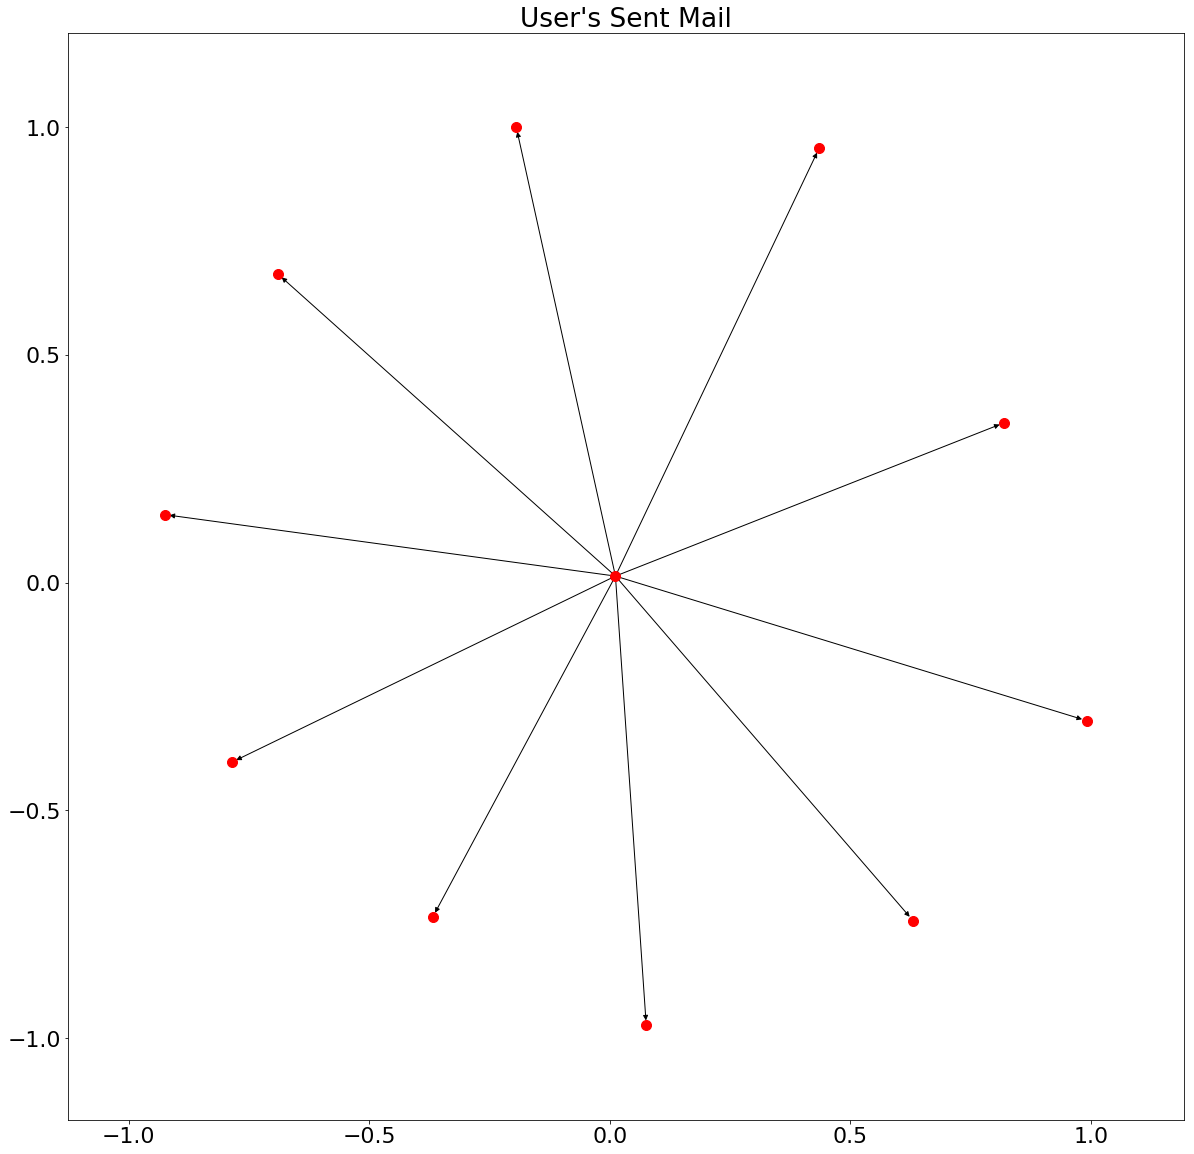

In [287]:
# Plot it
figure(figsize=(20, 20))
nx.draw_networkx(G, with_labels=False, font_size=20, node_size=100, style='dashed')
plt.title("User's Sent Mail")
plt.show()

Name: 
Type: DiGraph
Number of nodes: 340
Number of edges: 6700
Average in degree:  19.7059
Average out degree:  19.7059


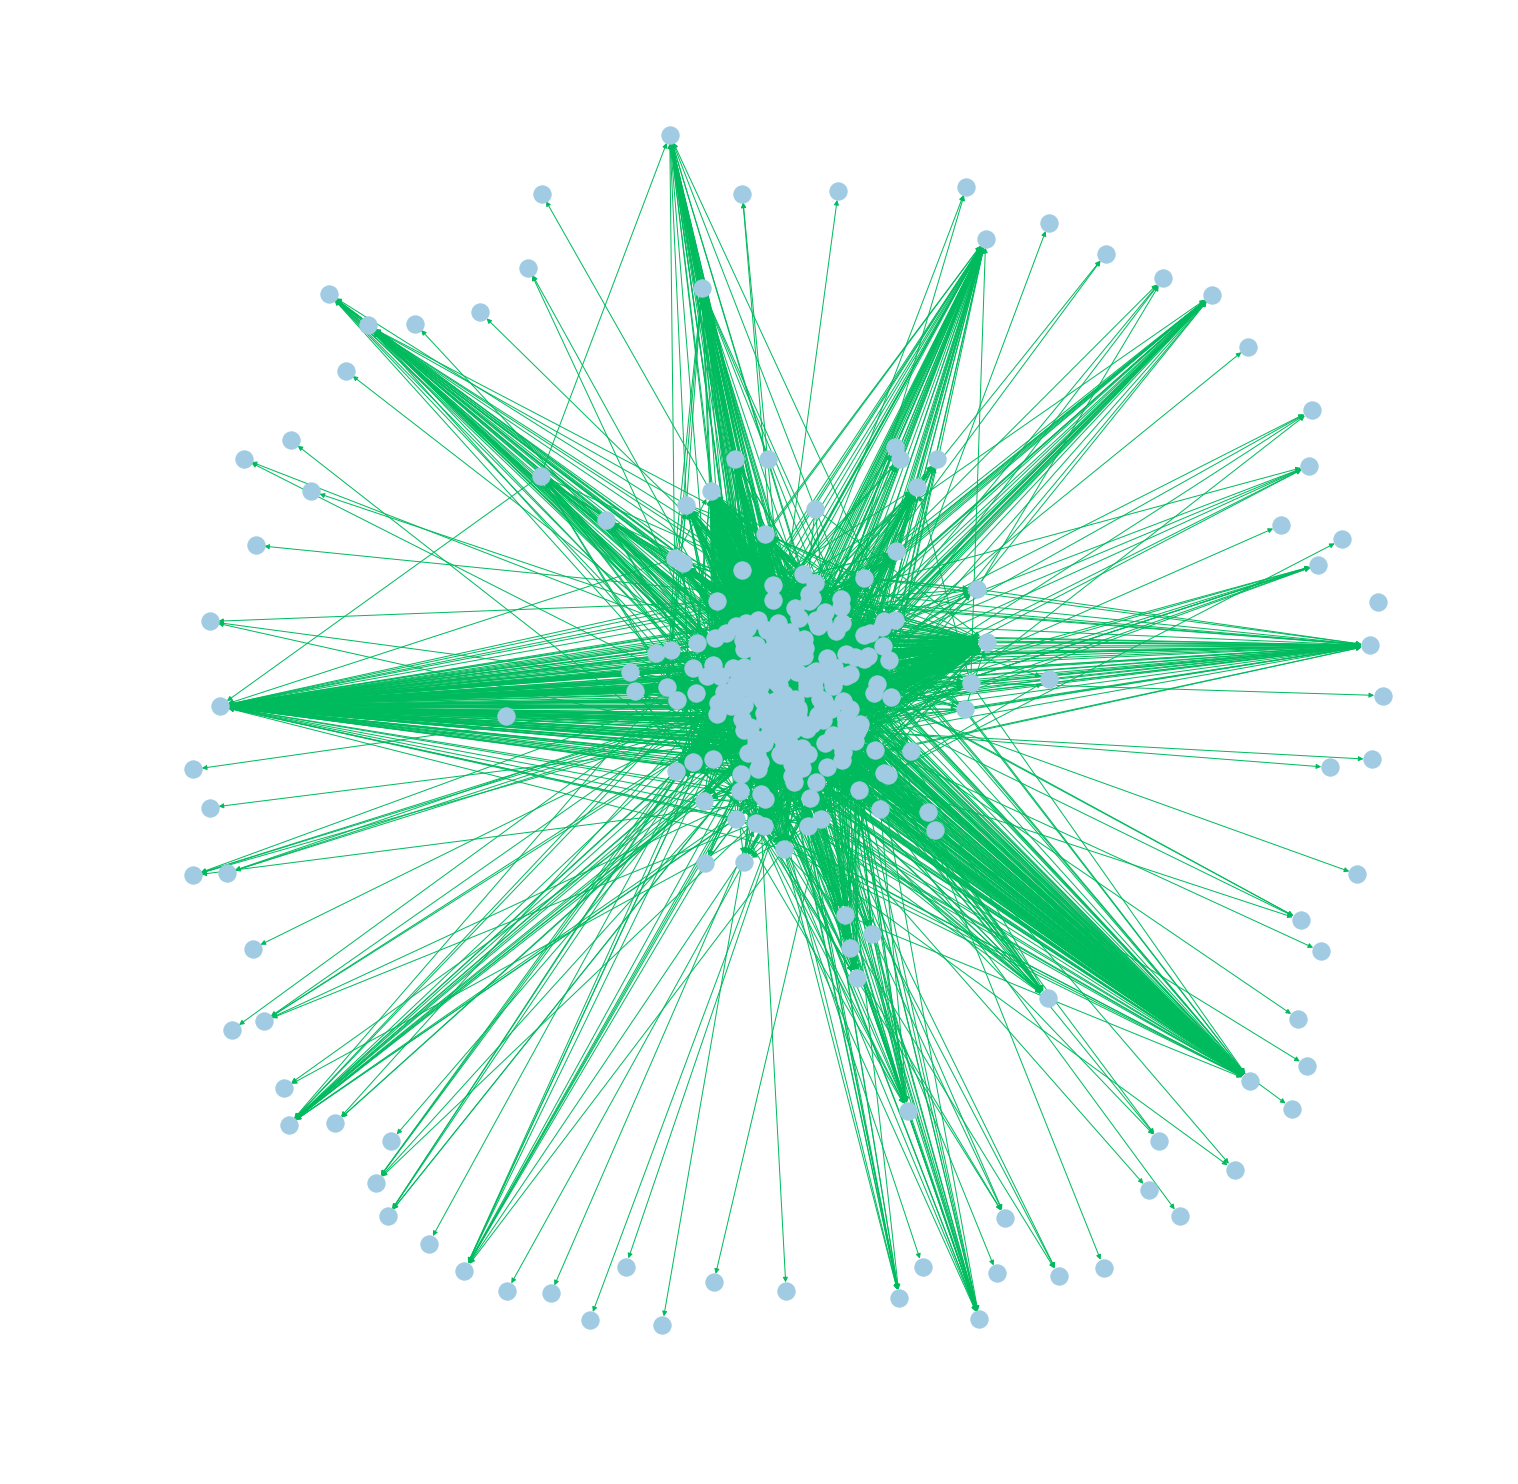

In [256]:
"""
Here we load the pandas data frame into
a directional graph with source and 
target columns. Then we plot the graph and
list out some info on it.
"""
# Build your graph
G = nx.from_pandas_edgelist(
    user_inbox_df,
    source='user',
    target='from_address',
    edge_attr=True,
    create_using=nx.DiGraph(),
)

#plotting the graph
pos = nx.spring_layout(G)
figure(figsize=(20, 20))
nx.draw(
    G,
    pos,
    node_color='#A0CBE2',
    edge_color='#00bb5e',
    width=1,
    edge_cmap=plt.cm.Blues,
    with_labels=False,
)
plt.savefig("graph_sample.pdf")
print(nx.info(G))


So, the total number of unique nodes in this network are 340 and the total number of edges in the network are 6700. Note that we are provided with edges/links and not nodes.
Therefore, the total number of possible edges/links/connections in this network could be 340 C 2. Out of these, we are provided with only 6700. The remaining 340 C 2–670 edges do not exist in the network.

### What we need to for model development

The email friend recommendation can be defined as a binary classification problem which takes a set of features from the users and maps them to 1 if there exists a link between a pair and 0 for a non-link.

Therefore, we need to create an indicator variable for link which will be 1 if there is a link between two nodes and 0 if there is no link between the two nodes. However, in our data we are provided with all the links in the given network. So the remaining 340 C 2–6700 combinations of nodes do not have any links between them. We cannot take all of the remaining combinations because doing so will give us an entirely biased dataset. We will be randomly sampling 6700 from it to get a balanced dataset. Therefore, the final size of the data will be 6700 x 2 = 13400. Our final dataset will have 6700 rows with indicator variable 1 and 6700 rows with indicator variable 0.

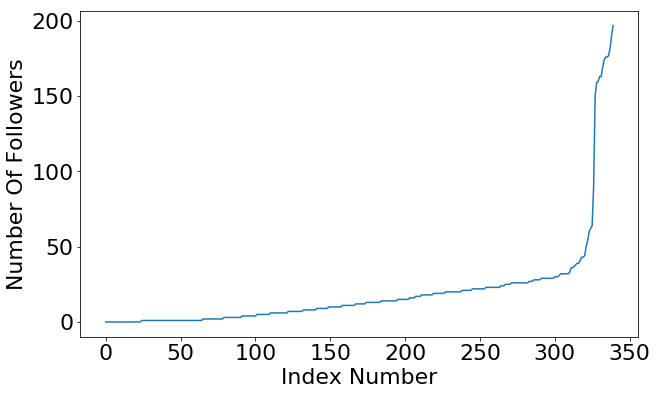

In [232]:
"""
Here’s the distribution of number of followers of each 
node in the training set as well as the number of followees 
of each nodes.
"""
# Followers
indegree_dist = list(dict(G.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index Number')
plt.ylabel('Number Of Followers')
plt.show()

In [235]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 32.0
91 percentile value is 32.0
92 percentile value is 36.0
93 percentile value is 39.0
94 percentile value is 43.0
95 percentile value is 54.30000000000007
96 percentile value is 75.43999999999994
97 percentile value is 159.82999999999998
98 percentile value is 170.09999999999985
99 percentile value is 176.61
100 percentile value is 197.0


In [236]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 176.949
99.2 percentile value is 178.44000000000005
99.3 percentile value is 180.13500000000005
99.4 percentile value is 181.83000000000004
99.5 percentile value is 184.44000000000005
99.6 percentile value is 187.15200000000004
99.7 percentile value is 189.86400000000003
99.8 percentile value is 192.25400000000002
99.9 percentile value is 194.6270000000004
100.0 percentile value is 197.0


### Observations:
- Most of the users in this network have followers in the range of 30 to 75.
- The maximum number of followers by a user is 197.

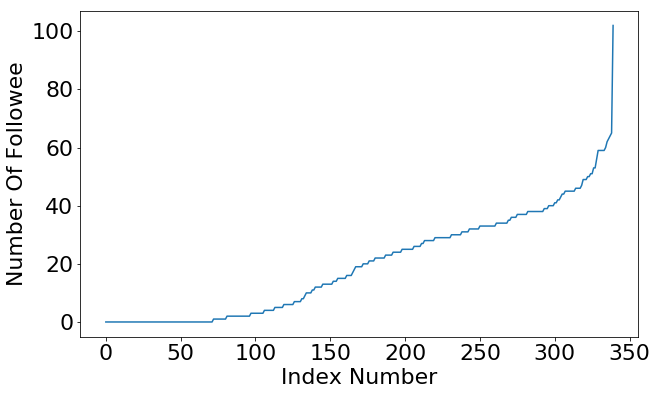

In [237]:
# Followees
outdegree_dist = list(dict(G.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index Number')
plt.ylabel('Number Of Followee')
plt.show()

In [239]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 44.0
91 percentile value is 45.0
92 percentile value is 45.0
93 percentile value is 46.0
94 percentile value is 48.319999999999936
95 percentile value is 50.0
96 percentile value is 51.879999999999995
97 percentile value is 58.48999999999995
98 percentile value is 59.0
99 percentile value is 62.610000000000014
100 percentile value is 102.0


In [240]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 62.94900000000001
99.2 percentile value is 63.28800000000001
99.3 percentile value is 63.62700000000001
99.4 percentile value is 63.96600000000001
99.5 percentile value is 64.305
99.6 percentile value is 64.644
99.7 percentile value is 64.983
99.8 percentile value is 76.9140000000001
99.9 percentile value is 89.45700000000215
100.0 percentile value is 102.0


### Observations:
- Most of the users in this network have followers in the range of 40 to 64.
- The maximum number of followers by a user is 102.

In [246]:
print(
    'Number of users that are not following anyone are', 
    sum(np.array(outdegree_dist)==0),
    'and % is',
    sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist)
)

Number of users that are not following anyone are 72 and % is 21.176470588235293


In [244]:
print(
    'Number of users who have no followers',
    sum(np.array(indegree_dist)==0),
    'and % is',
    sum(np.array(indegree_dist)==0)*100/len(indegree_dist)
)

Number of users who have no followers 24 and % is 7.0588235294117645


### Observations:
- Notice that 21.18% of the users in our data have 0 followees and 7.05% of users have 0 followers.

## Data Prep

In [343]:
"""
First we need to convert the data from MS Graph in to the 
right format.
"""
user_mapping = user_inbox_df.copy()

def create_source_nodes(val, universe = universe):
    return universe.index(val)

universe = user_mapping.user.unique().tolist() + user_mapping.from_address.unique().tolist()
user_mapping['source_node'] = user_mapping['user'].apply(lambda x: create_source_nodes(x))


In [344]:
def create_destination_nodes(val, universe = universe):
    return universe.index(val)

universe = user_mapping.from_address.tolist()
user_mapping['destination_node'] = user_mapping['from_address'].apply(lambda x: create_destination_nodes(x))


In [348]:
user_network = user_mapping[['source_node', 'destination_node']]
user_network.head()

,source_node,destination_node
0,0,62
1,0,44
2,0,270
3,0,271
0,0,195


In [349]:
"""Generating missing edges from given graph"""
r = user_network
# the dict will contain a tuple of 2 nodes as key and
# the value will be 1 if the nodes are connected else -1
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1
    
missing_edges = set([])
while (len(missing_edges)<22894):
    a = random.randint(1, 340)
    b = random.randint(1, 340)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a != b:
        try:
            # adding points who less likely to be friends
            if nx.shortest_path_length(g,source=a,target=b) > 2:
                missing_edges.add((a,b))
            else:
                continue
        except:
            missing_edges.add((a,b))              
    else:
        continue

In [350]:
# Sanity check
len(missing_edges)

22894

In [351]:
# Save this in a pickle
pickle.dump(
    missing_edges,
    open('missing_edges_final.p','wb')
)

In [589]:
"""
Save the two lists as positive and negative data 
points and performing test-train split.
"""
# reading total data df
df_pos = user_network
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

# Create the indicator_link variable for each df
df_pos['indicator_link'] = 1
df_neg['indicator_link'] = 0

print("Number of nodes in the graph with edges", df_pos.shape)
print("Number of nodes in the graph without edges", df_neg.shape)

Number of nodes in the graph with edges (22894, 3)
Number of nodes in the graph without edges (22894, 3)


In [512]:
df_neg.head()

,source_node,destination_node,indicator_link
0,309,204,0
1,184,26,0
2,156,192,0
3,52,17,0
4,303,128,0


In [513]:
"""
Trian test split (80-20)
positive links and negative links seperatly 
because we need positive training data only for creating graph 
and for feature generation
"""
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(
    df_pos,
    np.ones(len(df_pos)),
    test_size=0.2,
    random_state=9
)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(
    df_neg,
    np.zeros(len(df_neg)),
    test_size=0.2,
    random_state=9
)
print('='*60)
print(
    "Number of nodes in the train data graph with edges",
    X_train_pos.shape,
    "=",
    y_train_pos.shape
)
print("Number of nodes in the train data graph without edges",
      X_train_neg.shape,
      "=",
      y_train_neg.shape
)
print('='*60)
print("Number of nodes in the test data graph with edges",
      X_test_pos.shape,
      "=",
      y_test_pos.shape
)
print("Number of nodes in the test data graph without edges",
      X_test_neg.shape,
      "=",
      y_test_neg.shape
)

Number of nodes in the train data graph with edges (18315, 3) = (18315,)
Number of nodes in the train data graph without edges (18315, 3) = (18315,)
Number of nodes in the test data graph with edges (4579, 3) = (4579,)
Number of nodes in the test data graph without edges (4579, 3) = (4579,)


In [514]:
"""removing header and saving"""
X_train_pos.to_csv('train_pos_after_eda.csv', header=False, index=False)
X_test_pos.to_csv('test_pos_after_eda.csv', header=False, index=False)
X_train_neg.to_csv('train_neg_after_eda.csv', header=False, index=False)
X_test_neg.to_csv('test_neg_after_eda.csv', header=False, index=False)


In [516]:
"""
4 people are present in the 42 set but not in the train set, 
this may be an issue when our model is leanring. Let's fix 
this by concatenating the positive and negative edges together.
"""
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path.isfile('test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('train_pos_after_eda.csv',
                              names=['source_node', 'destination_node', 'indicator_link'])
    X_test_pos = pd.read_csv('test_pos_after_eda.csv', 
                             names=['source_node', 'destination_node', 'indicator_link'])
    X_train_neg = pd.read_csv('train_neg_after_eda.csv', 
                              names=['source_node', 'destination_node', 'indicator_link'])
    X_test_neg = pd.read_csv('test_neg_after_eda.csv', 
                             names=['source_code', 'destination_node', 'indicator_link'])

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg))

X_train.to_csv('train_after_eda.csv', header=False, index=False)
X_test.to_csv('test_after_eda.csv', header=False, index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv', header=False, index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv', header=False, index=False)

Number of nodes in the train data graph with edges 18315
Number of nodes in the train data graph without edges 18315
Number of nodes in the test data graph with edges 4579
Number of nodes in the test data graph without edges 4579


## Feature Engineering

Now, our dataset has no real features in it for our classification task. So, we will create some of our own to work with.

Features include:
1. Jaccard Distance
    - The Jaccard Index measures the similarity between finite sets and is defined as the size of the intersection divided by the union of the sample sets. The Jaccard distance which measures the similarity between sample sets is complimentary to Jaccard index and is obtained by subtracting the Jaccard index by 1.
    
2. Cosine Distance
    - Cosine distance is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.
    
3. Page rank
    - PageRank works by counting the number and quality of links to a page(nodes in this case) to determine a rough estimate of how important the website(node) is.
    
4. Shortest path
    - The shortest path is the path between two nodes such that the sum of their weights is minimum.

5. Weakly connected components
    - A particular component is said to be strongly connected if there is at least one path from any given node to any other node. A directed graph is weakly connected if replacing all its directed edges with undirected edges. Therefore, every strongly connected component is a weakly connected component. However, if it is not a strongly connected component, then to check whether it is a weakly connected component remove the directions of the edges and see if still there is at least one path from any given node to any other node.

6. Adar Index
    - Adamic/Adar measures are defined as an inverted sum of degrees of common neighbors for given two vertices. This measures the closeness of two nodes based on their shared neighbors. A value 0 indicates that two nodes are not close, while higher values indicate nodes are close.

7. Follow back
    - This feature is a simple one which is used to find out if a node follows back after being followed by another node.

8. Katz Centrality
    - Katz centrality of a node is a measure of centrality in a network. Katz centrality measures the influence by taking into account the total number of walks between a pair of actors.
    
9. HITS
    - Hyper-link induced topic search (HITS) identifies good authorities and hubs for a topic by assigning two numbers to a node: an authority and a hub weight. Authorities estimate the node value based on the incoming links. Hubs estimate the node value based on outgoing links.

In [368]:
# Jaccard Distance
# Will implament for both followees and followers
def jaccard_for_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim


def jaccard_for_followers(a, b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0


In [369]:
# Cosine Distance
# Will implament for both followees and followers
def cosine_for_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0


def cosine_for_followers(a, b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0


In [445]:
# Page Rank
pr = nx.pagerank(train_graph, alpha=0.85)
pickle.dump(pr, open('page_rank.p','wb'))
mean_pr = float(sum(pr.values())) / len(pr)

print('min', pr[min(pr, key=pr.get)])
print('max', pr[max(pr, key=pr.get)])
print('mean', float(sum(pr.values())) / len(pr))

min 0.0008623424846157849
max 0.14766055525323868
mean 0.002976190476190476


In [370]:
# Shortest Distance
def compute_shortest_path_length(a, b):
    p = -1
    try:
        if train_graph.has_edge(a, b):
            train_graph.remove_edge(a, b)
            p = nx.shortest_path_length(train_graph, source=a, target=b)
            train_graph.add_edge(a, b)
        else:
            p = nx.shortest_path_length(train_graph, source=a, target=b)
        return p
    except:
        return -1

In [398]:
# Weakly connected components 
wcc = list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0


In [371]:
# Adar Index
def calc_adar_in(a, b):
    sum = 0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum = sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [372]:
# Follow back
def follows_back(a, b):
    if train_graph.has_edge(b, a):
        return 1
    else:
        return 0

In [446]:
# Katz Centrality
katz = nx.katz.katz_centrality(train_graph, alpha=0.005, beta=1)
pickle.dump(katz, open('katz.p', 'wb'))
mean_katz = 0.0539

print('min', katz[min(katz, key=katz.get)])
print('max', katz[max(katz, key=katz.get)])
print('mean', float(sum(katz.values())) / len(katz))

min 0.04912231433890002
max 0.10026832175131421
mean 0.053977819218479155


In [447]:
# HITS
hits = nx.hits(
    train_graph,
    max_iter=100,
    tol=1e-08,
    nstart=None,
    normalized=True
)
pickle.dump(hits, open('hits.p','wb'))

print('min', hits[0][min(hits[0], key=hits[0].get)])
print('max', hits[0][max(hits[0], key=hits[0].get)])
print('mean', float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.008182306114134183
mean 0.002976190476190476


In [517]:
# start_time = time()
df_final_train = X_train
df_final_test = X_test
# Mapping Jaccrd followers to train and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                                           jaccard_for_followers(
                                                               row['source_node'],
                                                               row['destination_node']),
                                                           axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                                         jaccard_for_followers(
                                                             row['source_node'],
                                                             row['destination_node']),
                                                         axis=1)

# Mapping Jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                                           jaccard_for_followees(
                                                               row['source_node'],
                                                               row['destination_node']),
                                                           axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                                         jaccard_for_followees(
                                                             row['source_node'],
                                                             row['destination_node']),
                                                         axis=1)


# Mapping Cosine followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                                          cosine_for_followers(
                                                              row['source_node'],
                                                              row['destination_node']),
                                                          axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                                        cosine_for_followers(
                                                            row['source_node'],
                                                            row['destination_node']),
                                                        axis=1)

# Mapping Cosine followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                                          cosine_for_followees(
                                                              row['source_node'],
                                                              row['destination_node']),
                                                          axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                                        cosine_for_followees(
                                                            row['source_node'],
                                                            row['destination_node']),
                                                        axis=1)

In [518]:
def compute_features_stage1(df_final):
    # Calculating number of followers and followees for source and destination nodes
    # Calculating intersection of followers and followees for source and destination nodes
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for index, row in df_final.iterrows():
        try:
            s1 = set(train_graph.predecessors(row['source_node']))
            s2 = set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1 = set(train_graph.predecessors(row['destination_node']))
            d2 = set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees'] = compute_features_stage1(df_final_train)
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees'] = compute_features_stage1(df_final_test)

In [568]:
# Mapping adar index on train and test
df_final_train['adar_index'] = df_final_train.apply(lambda row:
                                                    calc_adar_in(
                                                        row['source_node'],
                                                        row['destination_node']),
                                                    axis=1)

df_final_test['adar_index'] = df_final_test.apply(lambda row:
                                                  calc_adar_in(
                                                      row['source_node'],
                                                      row['destination_node']),
                                                  axis=1)

# Mapping followback or not on train and test
df_final_train['follows_back'] = df_final_train.apply(lambda row:
                                                      follows_back(
                                                          row['source_node'],
                                                          row['destination_node']),
                                                      axis=1)

df_final_test['follows_back'] = df_final_test.apply(lambda row:
                                                    follows_back(
                                                        row['source_node'],
                                                        row['destination_node']),
                                                    axis=1)

# Mapping same component of wcc or not on train and test
df_final_train['same_comp'] = df_final_train.apply(lambda row:
                                                   belongs_to_same_wcc(
                                                       row['source_node'],
                                                       row['destination_node']),
                                                   axis=1)

df_final_test['same_comp'] = df_final_test.apply(lambda row:
                                                 belongs_to_same_wcc(
                                                     row['source_node'],
                                                     row['destination_node']),
                                                 axis=1)

# Mapping shortest path on train and test
df_final_train['shortest_path'] = df_final_train.apply(lambda row:
                                                       compute_shortest_path_length(
                                                           row['source_node'],
                                                           row['destination_node']),
                                                       axis=1)

df_final_test['shortest_path'] = df_final_test.apply(lambda row:
                                                     compute_shortest_path_length(
                                                         row['source_node'],
                                                         row['destination_node']),
                                                     axis=1)

# Mapping page rank on train and test
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:
                                                                 pr.get(x,mean_pr))

df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:
                                                                      pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:
                                                               pr.get(x,mean_pr))

df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:
                                                                    pr.get(x,mean_pr))

# Katz centrality score for source and destination in train and test
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x:
                                                            katz.get(x,mean_katz))

df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x:
                                                                 katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x:
                                                          katz.get(x,mean_katz))

df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x:
                                                               katz.get(x,mean_katz))

# Hits algorithm score for source and destination in train and test
# For hub's and authorities
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x:
                                                            hits[0].get(x,0))

df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x:
                                                                 hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x:
                                                          hits[0].get(x,0))

df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x:
                                                               hits[0].get(x,0))

df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x:
                                                                   hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x:
                                                                        hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x:
                                                                 hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x:
                                                                      hits[1].get(x,0))


In [520]:
# Sanity Check
df_final_train.tail()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
36625,16,323,0,0,0.0000,0,0,125,0,18,...,0,-1,0.009655,0.002976,0.082884,0.053900,0.002696,0.000000,0.021880,0.000000
36626,150,248,0,0,0.3125,0,0,0,4,17,...,1,3,0.000862,0.001090,0.049122,0.050230,0.004896,0.005134,0.000000,0.000790
36627,324,220,0,0,0.0000,0,0,0,6,0,...,0,-1,0.002976,0.001257,0.053900,0.050756,0.000000,0.005418,0.000000,0.001021
36628,165,212,0,0,0.1250,0,0,26,19,55,...,1,3,0.003670,0.002232,0.056560,0.054231,0.006976,0.004417,0.003946,0.003376
36629,49,62,0,0,0.1250,0,0,9,51,25,...,1,2,0.001374,0.004798,0.051544,0.062973,0.005080,0.002770,0.001499,0.008608


In [480]:
# Sanity Check
df_final_test.tail()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
9153,27,324,0,0,0.000000,0,0,27,0,10,...,0,-1,0.003276,0.002976,0.056748,0.053900,0.000846,0.000000,0.005114,0.000000
9154,184,132,0,0,0.000000,0,0,4,12,0,...,1,-1,0.001517,0.002682,0.050194,0.052353,0.000000,0.005263,0.000407,0.001460
9155,267,80,0,0,0.145455,0,0,15,14,35,...,1,2,0.001837,0.002397,0.053268,0.053158,0.005667,0.004819,0.002680,0.002347
9156,299,320,0,0,0.000000,0,0,0,0,0,...,0,-1,0.002976,0.002976,0.053900,0.053900,0.000000,0.000000,0.000000,0.000000
9157,256,171,0,0,0.195122,0,0,8,20,21,...,1,2,0.001683,0.003840,0.051437,0.054762,0.005267,0.002891,0.001409,0.002899


In [587]:
# df_final_train.shape

In [588]:
# df_final_test.shape

## Model Building

Since we have completed our feature engineering tasks and have a hand full of feature tol use for our classification task, let's start the modleing process

In [570]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(25,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [531]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

X_train = df_final_train.copy()
X_test = df_final_test.copy()

X_train.drop(['source_node', 'destination_node','indicator_link'],
             axis=1,
             inplace=True)
X_test.drop(['source_node', 'destination_node','indicator_link'],
            axis=1,
            inplace=True)

X_train = X_train.round(4)
X_test = X_test.round(4)

In [560]:
# Don't need these
del X_train['jaccard_followees']
del X_train['jaccard_followers']
del X_train['cosine_followers']
del X_train['cosine_followees']

del X_test['jaccard_followees']
del X_test['jaccard_followers']
del X_test['cosine_followers']
del X_test['cosine_followees']

In [553]:
# Find inf/-inf and replace with NaN then fill with 0
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(0)

X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(0)

In [583]:
# len(y_train)

In [584]:
# len(y_test)

In [585]:
# X_test.shape

In [586]:
# X_train.shape

### Linear SVM

SVC accuracy = 0.9012884909368858
SVC metric report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4579
           1       0.89      0.91      0.90      4579

   micro avg       0.90      0.90      0.90      9158
   macro avg       0.90      0.90      0.90      9158
weighted avg       0.90      0.90      0.90      9158



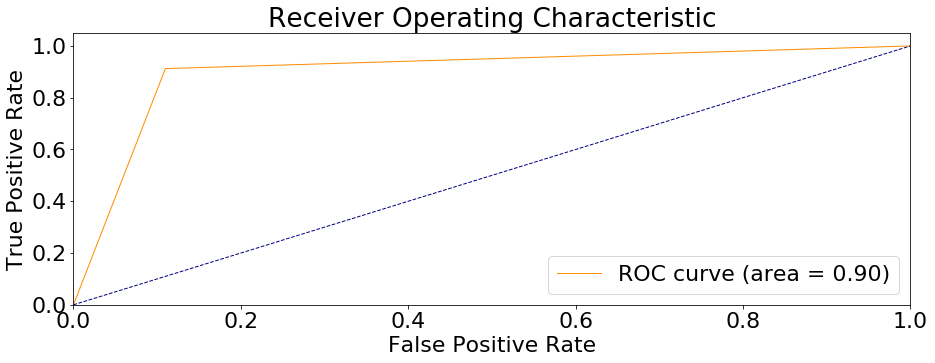

Test confusion_matrix


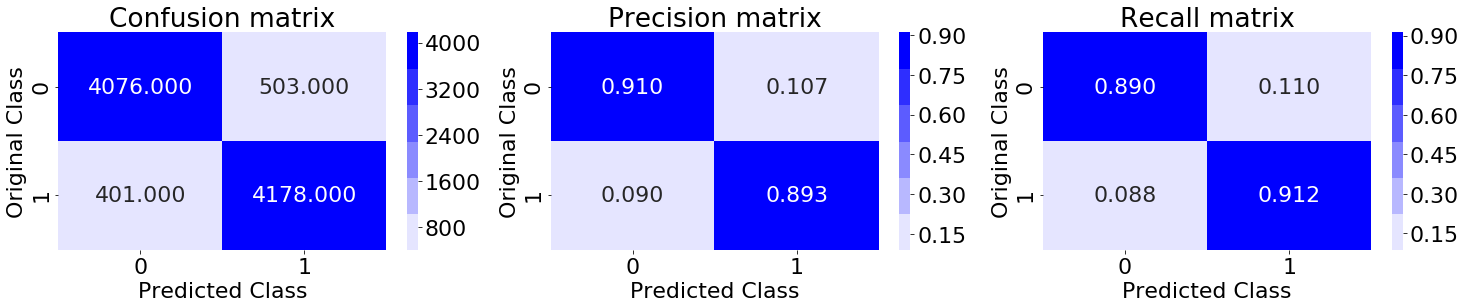

In [582]:
# In this snippet we make use of a PCA to evaluate feature importances and 
# select the most relevant features. Then, a SVM is trained on the transformed output, 
# i.e. using only relevant features.

# First we need to set up the PipeLine that will take the PCA and then fit a GNB classifier
SVC_pipe = Pipeline([('PCA', PCA(n_components=5, 
                                 svd_solver='randomized')),
                     ('classification', SVC(kernel='rbf',
                                            gamma='scale',
                                            random_state=111))
                    ])

SVC_pipe.fit(X_train, y_train)  # train object
y_hat = SVC_pipe.predict(X_test) #get the test set predictions 

# Accuracy for the iterations of training/testing
accuracy_SVC_pipe = mt.accuracy_score(y_test, y_hat)
print('SVC accuracy =', accuracy_SVC_pipe)

# Metric report 
metrics_SVC_pipe = classification_report(y_test, y_hat)
print('SVC metric report')
print(metrics_SVC_pipe)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(15,5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
print('Test confusion_matrix')
plot_confusion_matrix(y_test, y_hat)

### Logistic Regression

Logistic Regression accuracy = 0.8930989298973575
Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4579
           1       0.89      0.90      0.89      4579

   micro avg       0.89      0.89      0.89      9158
   macro avg       0.89      0.89      0.89      9158
weighted avg       0.89      0.89      0.89      9158



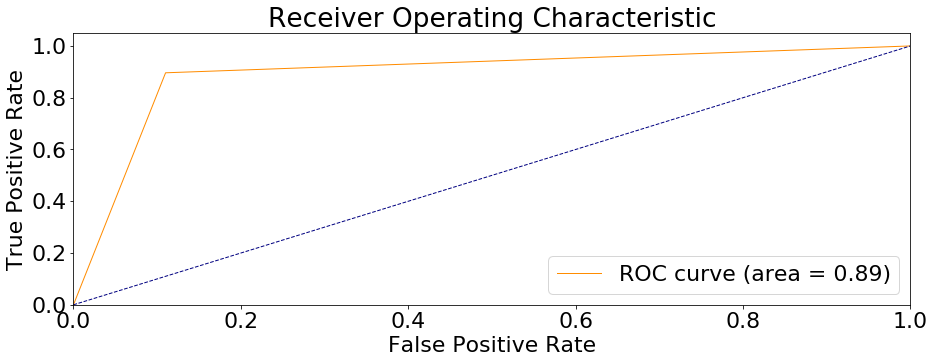

Test confusion_matrix


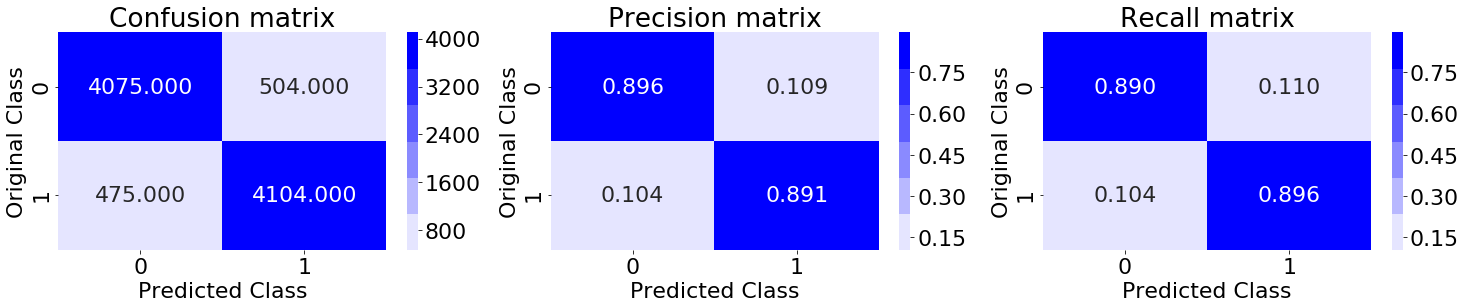

In [581]:
# Logistic Regression

# penalty -> Specifies the norm used in the penalization. Here we use the default 'L2' or Euclidean norm/distance.
#            In other words the sum of the squares of the elements gives one.
# solver -> 'lbfgs' or Limited-memory BFGS is used here. 
# dual -> Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False 
#         when n_samples > n_features.


logit = LogisticRegression(penalty='l2',
                           solver='liblinear',
                           max_iter=500,
                           dual=False,
                           random_state = 111)


# Train the reusable SVM classifier on the training data
logit.fit(X_train, y_train)
# Get the test set predictions 
y_hat = logit.predict(X_test)

# Accuracy for the iterations of training/testing
accuracy_logit = mt.accuracy_score(y_test, y_hat)
# Print out each numbered iteration 
print('Logistic Regression accuracy =', accuracy_logit)

# Metric report 
metrics_logit = classification_report(y_test, y_hat)
print('Logistic Regression Metric Report')
print(metrics_logit)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(15,5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
print('Test confusion_matrix')
plot_confusion_matrix(y_test, y_hat)

## Model Comparison

Here we will go through comparing the two methods used by looking at the model performance metrics precision, recall, and $F_{1}$-score. We will also use visualizations to help us gauge how well each method did at classifying our output. These visualizations include a confusion matrix and a receiver operating characteristic curve (ROC curve).

##### Precision
    This talks about how precise/accurate our model is out of those predicted positive, how many of them are a true positive.
    
    For each method, we have high numbers. The precision ranges from 0.90 to 0.91. Meaning that the cost of a False Positive is low. 
    
##### Recall (aka sensitivity)
    This talks about how many of the true positives our model captures through labeling it as true positive. For each method, we have high numbers. The recall is 0.89 for both models.
    
##### $F_{1}$-score
    This is a weighted average of the true positive rate (recall) and precision. For each method, we have high numbers. The recall ranges from 0.89 to 0.90.
    
##### False positive, Type 1 Error
    This means that we have predicted a link as a link when in fact it is non-link. Both methods result in very similar false positives. Each model produces very similar results here, SVM 503 and Logistic Regression is 504.
    
##### False negative, Type 2 Error
    This means that we have predicted a transaction non-link when it is linked. Both methods show very similar numbers; SVM = 401 and Logistic Regression = 475.
    
##### ROC (Receiver Operating Characteristic)
    This is a graphical representation of how well the binary classifier system performs. It summarizes the model’s performance by evaluating the trade-offs between the true positive rate (sensitivity) and false-positive rate(1- specificity).
    
    The area under the curve (AUC) is a performance metric for the ROC Curve. The higher the AUC, the better the prediction power of the model. Both methods have an area under the curve of about 0.90. This indicates that each method implemented performs well. 
    
    Our plot looks the way it does because the number of points depends on the number of unique values in the input. Since the input vector has only 2 unique values (0 or link and 1 or non-link) there are only 3 points. 

## Recommendation 

In many classification problems, you want the probability of class membership. That being said, it would be better to use a method like Logistic Regression, rather than post-process the output of the SVM to get probabilities. I would recommend using the Logistic Regression approach to this problem. However, before modeling, we need to do a substantial amount of pre-processing to clean and organize the input features. First, we will need a pipeline to pick the data up and ingest it, pre-process it, and then store the cleaned data. Then we can start the modeling process.